In [1]:
from astropy.io import ascii, fits
from astropy.table import Table
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
from copy import deepcopy
import batman
%matplotlib inline

In [2]:
namesList, mjdList = [], []
fileL = np.sort(glob.glob('../corot1/*flt.fits'))
for oneFile in fileL:
    head = fits.getheader(oneFile,ext=0)
    namesList.append(os.path.basename(oneFile))
    mjdList.append(head['EXPSTART'])
    
timeTable = Table()
timeTable['Name'] = namesList
timeTable['MJD'] = mjdList

In [3]:
boxdat = ascii.read('../corot1_tser/es_box_stats_lh.csv')

In [4]:
def addTimes(boxdat):
    mjdList2, filePrefixList = [], []
    for oneRow in boxdat:
        findExp = (timeTable['Name'] == oneRow['FILEN'])
        if np.sum(findExp) == 1:
            mjdList2.append(timeTable['MJD'][findExp][0])
        else:
            print(np.sum(findExp),' found for file',oneRow['FILEN'])
        filePrefixList.append(oneRow['FILEN'][0:6])
    boxdat['MJD'] = mjdList2
    boxdat['FilePrefix'] = filePrefixList
addTimes(boxdat)

In [5]:
visitList = np.unique(boxdat['FilePrefix'])
nVisit = len(visitList)

In [6]:
#Cperiod = 1.5089656 ## Bean 2009
#Tc = 2454159.452879 ## Bean 2009
Cperiod = 1.5089557 ## Barge 2008
Tc = 2454159.4532 ## Barge 2008
phase = np.mod((boxdat['MJD'] + 2400000.5 - Tc)/Cperiod,1.0)

In [7]:
phase2 = (boxdat['MJD'] + 2400000.5 - Tc)/Cperiod

In [8]:
params = batman.TransitParams()
params.t0 = 0.
params.per = 1.
params.rp = 0.1433
params.a = 4.751
params.inc = 83.88
params.ecc = 0.
params.w = 90.
params.u = [0.0, 0.0]
params.fp = 1e-3
params.t_secondary = 0.5
params.limb_dark = "quadratic"
tmodel = np.linspace(0.0,1.0,1024)
m = batman.TransitModel(params,tmodel)
s = batman.TransitModel(params,tmodel,transittype='secondary')
flux = m.light_curve(params)
flux2 = s.light_curve(params)

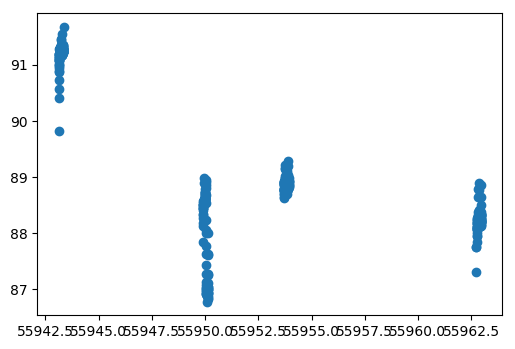

In [9]:
fig, ax = plt.subplots()
ax.plot(boxdat['MJD'],boxdat['MEAN'],marker='o',linestyle='')
plt.show()

In [10]:
def plot_tser(boxdat,genboxdat,phase,normalize=False):
    """ Plots the time series for all visits """
    fig, ax = plt.subplots()
    for visitInd, oneVisit in enumerate(visitList):
        pts = (oneVisit == genboxdat['FilePrefix'])
        if normalize == True:
            normVal = np.median(boxdat['MEAN'][pts])
        else:
            normVal = 1.0
        ax.plot(phase[pts],boxdat['MEAN'][pts]/normVal,marker='o',
                linestyle='',label="Visit {0}".format(visitInd+1))
    ax.legend()
    ax.set_xlabel('Orbital Phase')
    ax.set_ylabel('Flux')
    return fig, ax

## Box Time Series for each visit

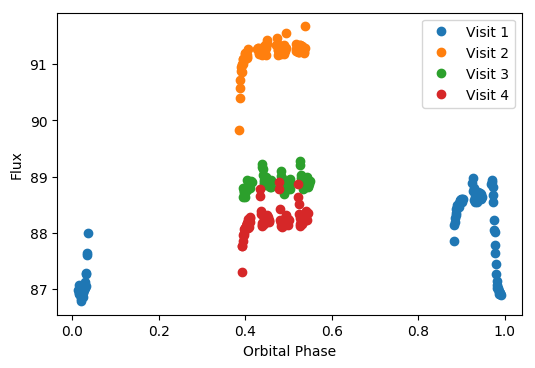

In [11]:
#%matplotlib notebook
fig, ax = plot_tser(boxdat,boxdat,phase)

### Normalized in each visit

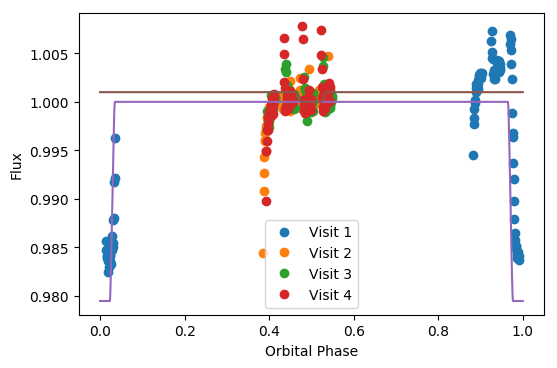

In [12]:
fig, ax = plot_tser(boxdat,boxdat,phase,normalize=True)
ax.plot(tmodel,flux)
ax.plot(tmodel,flux2)


### Zoom in on secondary eclipses all normalized per visit

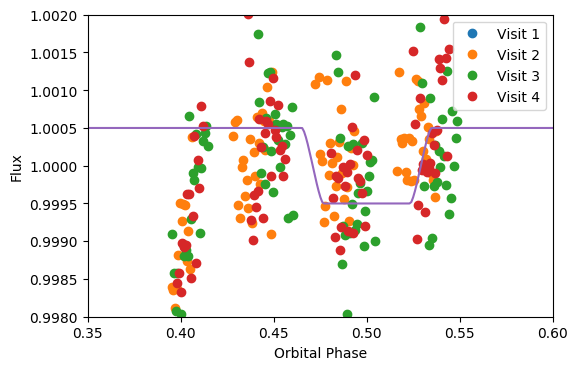

In [13]:
fig, ax = plot_tser(boxdat,boxdat,phase,normalize=True)
ax.set_xlim(0.35,0.6)
ax.set_ylim(0.998,1.002)
ax.plot(tmodel,flux2 - 5e-4)

## A different time series from the right hand side, a different wavelength

In [14]:
RHdat = ascii.read('../corot1_tser/es_box_stats_rh.csv')

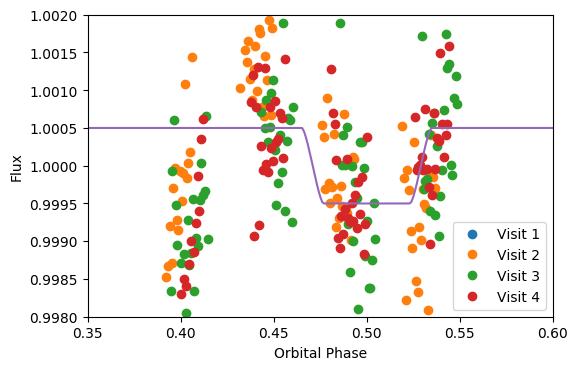

In [15]:
fig, ax = plot_tser(RHdat,boxdat,phase,normalize=True)
ax.set_xlim(0.35,0.6)
ax.set_ylim(0.998,1.002)
ax.plot(tmodel,flux2 - 5e-4)

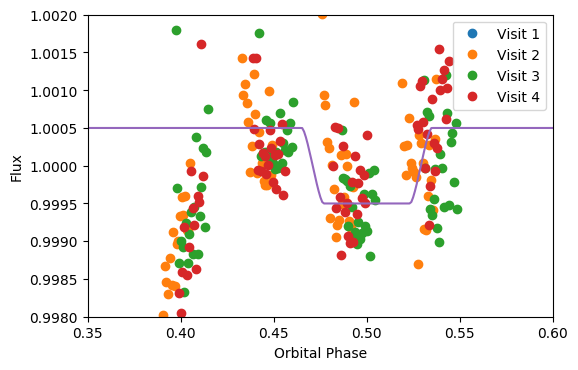

In [16]:
MidDat = ascii.read('../corot1_tser/es_box_stats_middle.csv')
fig, ax = plot_tser(MidDat,boxdat,phase,normalize=True)
ax.set_xlim(0.35,0.6)
ax.set_ylim(0.998,1.002)
ax.plot(tmodel,flux2 - 5e-4)

### Zoom in on primary transit

In [17]:
highPt = phase > 0.8
phase2 = deepcopy(phase)
phase2[highPt] = phase2[highPt] - 1.

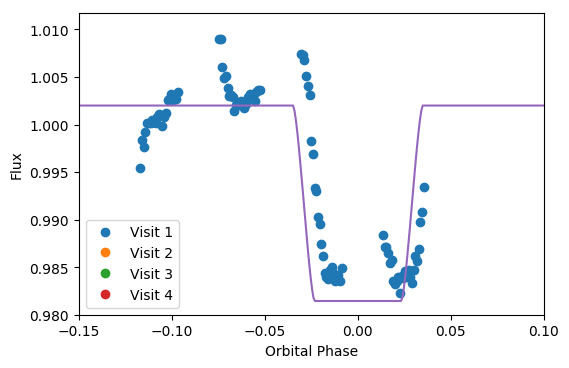

In [18]:
fig, ax = plot_tser(RHdat,boxdat,phase2,normalize=True)
ax.set_xlim(-0.15,0.1)
tmodel2 = np.linspace(-0.2,0.2,512)
m2 = batman.TransitModel(params,tmodel2)
flux3 = m2.light_curve(params)
ax.plot(tmodel2,flux3 + 2e-3)
#ax.set_ylim(0.998,1.002)

### Look at white light curve with a background subtraction

In [19]:
boxdatWL = ascii.read('../corot1_tser/es_box_stats_whitel.csv')
boxdatWLbackg = ascii.read('../corot1_tser/es_box_stats_whitel_backg.csv')
boxdatWL['MEAN'] = boxdatWL['MEAN'] - boxdatWLbackg['MEAN']

In [20]:
addTimes(boxdatWL)

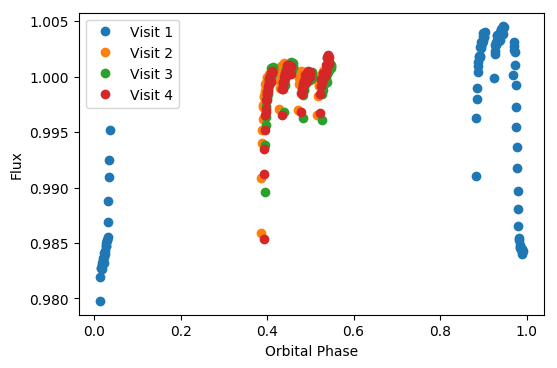

In [21]:
fig, ax = plot_tser(boxdatWL,boxdatWL,phase,normalize=True)
fig.savefig('all4_visits.pdf')

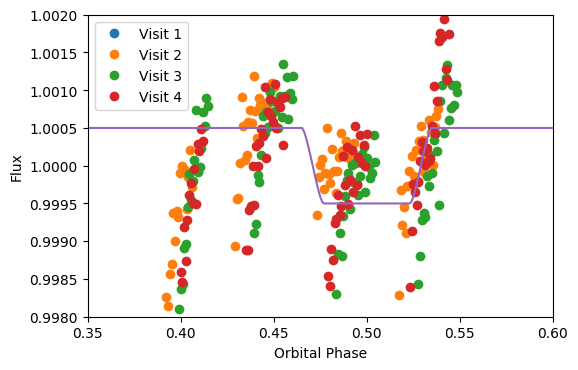

In [22]:
fig, ax = plot_tser(boxdatWL,boxdatWL,phase,normalize=True)
ax.set_xlim(0.35,0.6)
ax.set_ylim(0.998,1.002)
ax.plot(tmodel,flux2 - 5e-4)
fig.savefig('sec_eclipse_zoom.pdf',bbox_inches='tight')

In [23]:
!open .